csv licensed cc0
https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

conn = sqlite3.connect('f1.db')

for name in ['circuits', 'constructor_results', 'constructor_standings', \
             'constructors', 'driver_standings', 'drivers', 'lap_times', \
             'pit_stops', 'qualifying', 'races', 'results', 'seasons', \
             'sprint_results', 'status']:
    df = pd.read_csv(f'{name}.csv')
    print(name, df.shape)
    df.to_sql(name, conn, if_exists='replace', index=False)

circuits (77, 9)
constructor_results (12625, 5)
constructor_standings (13391, 7)
constructors (212, 5)
driver_standings (34863, 7)
drivers (861, 9)
lap_times (589081, 6)
pit_stops (11371, 7)
qualifying (10494, 9)
races (1125, 18)
results (26759, 18)
seasons (75, 2)
sprint_results (360, 16)
status (139, 2)


In [3]:
df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
df

,name
0,circuits
1,constructor_results
2,constructor_standings
3,constructors
4,driver_standings
5,drivers
6,lap_times
7,pit_stops
8,qualifying
9,races


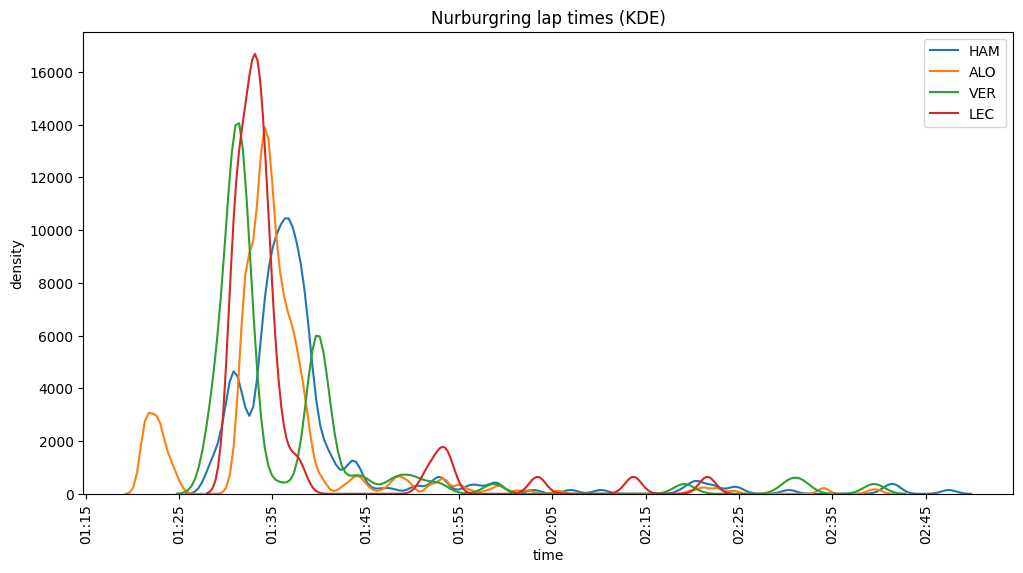

In [4]:
q = "SELECT milliseconds, code, nationality " \
    "FROM lap_times " \
    "INNER JOIN drivers ON lap_times.driverId = drivers.driverId " \
    "INNER JOIN races ON lap_times.raceId = races.raceId " \
    "INNER JOIN circuits ON races.circuitId = circuits.circuitId " \
    "WHERE circuits.circuitRef = 'nurburgring';"

df = pd.read_sql_query(q, conn)

df = df[df.milliseconds != '\\N']
df.milliseconds = pd.to_numeric(df.milliseconds)
df = df[(df.milliseconds > 0) & (df.milliseconds < 200000)]
df = df[df["code"].isin(["LEC", "HAM", "VER", "ALO"])]
df['time'] = pd.to_datetime(df.milliseconds, unit='ms')
# print(df.head())

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for code in df.code.unique():
    subset = df[df.code == code].time
    if subset.nunique() > 1:
        sns.kdeplot(subset, label=code, bw_adjust=0.2)
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.legend()
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('density')
plt.title('Nurburgring lap times (KDE)')
plt.show()

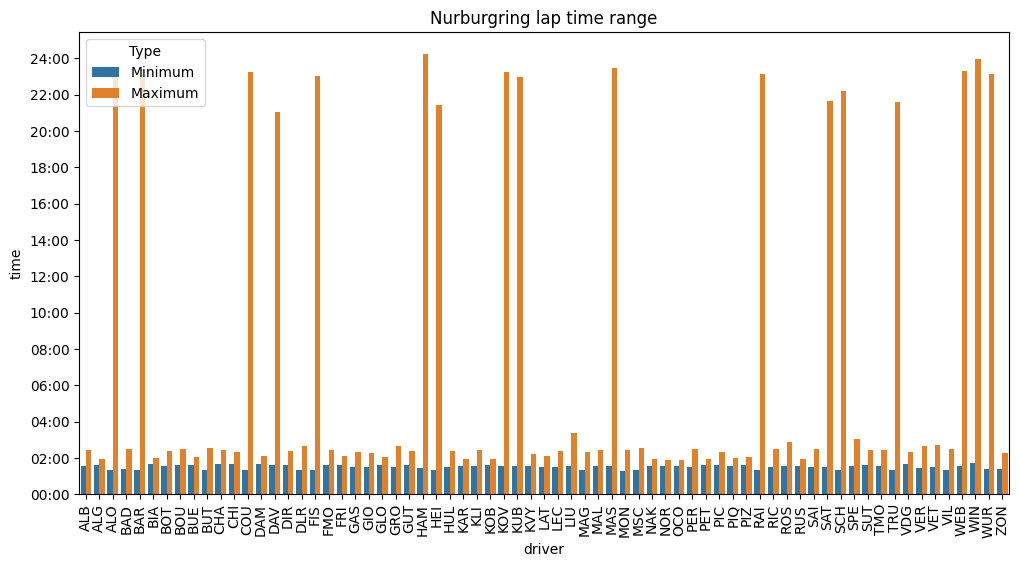

In [5]:
q = "SELECT milliseconds, code, nationality " \
    "FROM lap_times " \
    "INNER JOIN drivers ON lap_times.driverId = drivers.driverId " \
    "INNER JOIN races ON lap_times.raceId = races.raceId " \
    "INNER JOIN circuits ON races.circuitId = circuits.circuitId " \
    "WHERE circuits.circuitRef = 'nurburgring';"

df = pd.read_sql_query(q, conn)

df = df[df.milliseconds != '\\N']
df = df[df.code != '\\N']
df.milliseconds = pd.to_numeric(df.milliseconds)
df['time'] = pd.to_datetime(df.milliseconds, unit='ms')

data = df.groupby('code').agg(Minimum=('time', 'min'), Maximum=('time', 'max')).reset_index()
data_melted = data.melt(id_vars="code", 
                         value_vars=["Minimum", "Maximum"], 
                         var_name="Type", 
                         value_name="Time")

fig = plt.figure(figsize=(12, 6))
sns.barplot(data=data_melted, x="code", y="Time", hue="Type")
plt.xlabel('driver')
plt.xticks(rotation=90)
plt.ylabel('time')
ax = plt.gca()
ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S")) 
plt.title('Nurburgring lap time range')
plt.show()

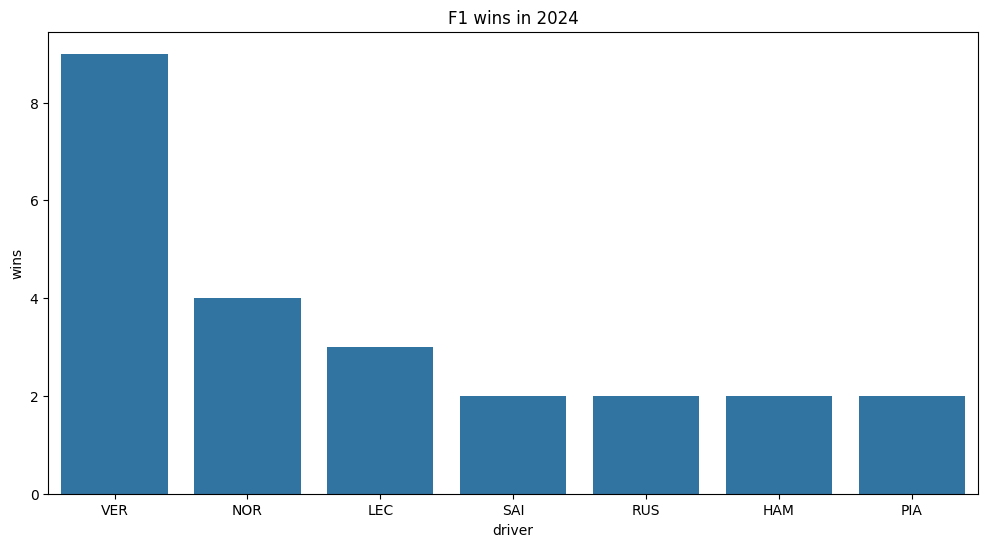

In [6]:
q = "SELECT code, year " \
    "FROM results " \
    "INNER JOIN races on results.raceId = races.raceId " \
    "INNER JOIN drivers on results.driverId = drivers.driverId " \
    "WHERE position = '1';"

df = pd.read_sql_query(q, conn)

season = 2024 # change this to the desired season

df = df[df.year == season]
df = df.code.value_counts().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='code', y='count')
plt.xlabel('driver')
plt.ylabel('wins')
plt.title(f'F1 wins in {season}')
plt.show()

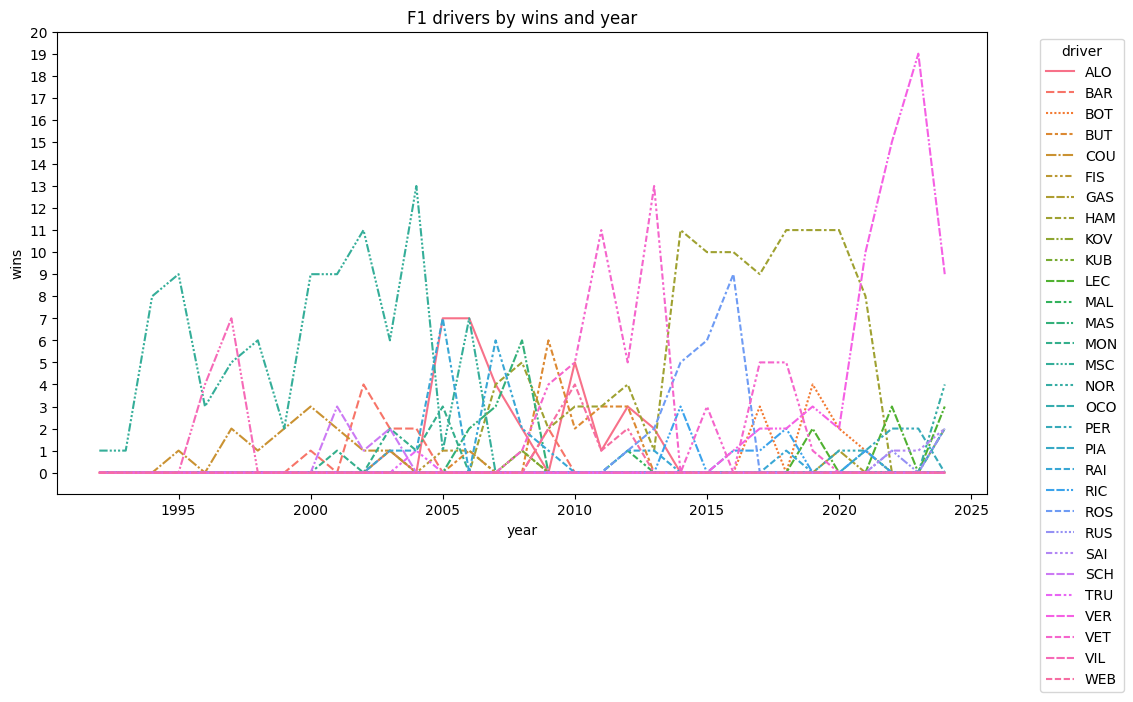

In [7]:
q = "SELECT code, year " \
    "FROM results " \
    "INNER JOIN races on results.raceId = races.raceId " \
    "INNER JOIN drivers on results.driverId = drivers.driverId " \
    "WHERE position = '1';"

df = pd.read_sql_query(q, conn)
df = df[df['code'] != '\\N']

s = df.groupby(['code', 'year']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=s.T)
plt.legend(title='driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('year')
plt.ylabel('wins')
plt.yticks(range(0, 21, 1))
plt.title('F1 drivers by wins and year')
plt.show()


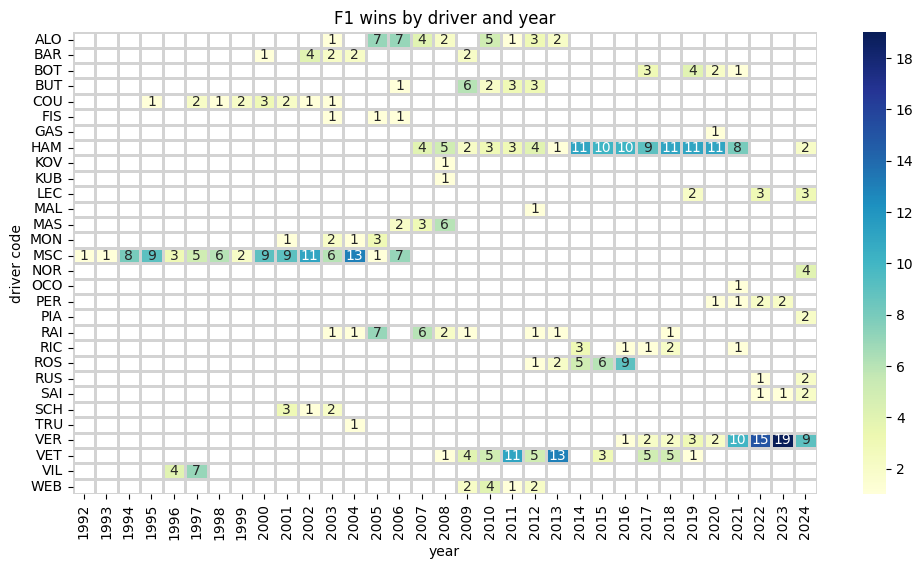

In [175]:
q = "SELECT code, year " \
    "FROM results " \
    "INNER JOIN races on results.raceId = races.raceId " \
    "INNER JOIN drivers on results.driverId = drivers.driverId " \
    "WHERE position = '1';"

df = pd.read_sql_query(q, conn)
df = df[df['code'] != '\\N']

plt.figure(figsize=(12, 6))
sns.heatmap(df.groupby(['code', 'year']).size().unstack(), cmap='YlGnBu', linecolor='lightgrey', linewidth=1, annot=True)
plt.xlabel('year')
plt.ylabel('driver code')
plt.title('F1 wins by driver and year')
plt.show()




In [22]:
q = "SELECT code, MAX(points) AS max_points " \
    "FROM driver_standings " \
    "INNER JOIN drivers ON driver_standings.driverId = drivers.driverId " \
    "GROUP BY code " \
    "ORDER BY max_points DESC;"

df = pd.read_sql_query(q, conn)
df = df[df['code'] != '\\N']
df.head(10)

,code,max_points
0,VER,575.0
1,HAM,413.0
2,VET,397.0
3,ROS,385.0
4,NOR,374.0
5,LEC,356.0
6,BOT,326.0
7,PER,305.0
8,PIA,292.0
9,SAI,290.0
